In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
#mnist_transform = transforms.Compose([
#                transforms.ToTensor(),
#                transforms.Normalize((0.5,), (0.5,)),
#           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [3]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        #self._conv4 = ConvLayer([64, 32, 2], padding=0, bn=batchnorm, stride=2, 
        #                        pool_layer=None, activation_fn=nn.Tanh())
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 64])
        self.fcd = FullyConnected([64, 32*2*2])
        
        #self._deconv1 = DeconvLayer([64, 64, 2], stride=2, padding=0, bn=batchnorm)
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)       
        l2 = self._conv2(l1)        
        l3 = self._conv3(l2) 
        #print ("l3=", l3.shape)
        #l4 = self._conv3(l3)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]       
        flatten = l3.view(-1, 32*2*2)       
        self.h = self.latent_fn(self.fce(flatten))
        return self.h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        #l4 = self._deconv2(l3)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):        
        h = self.encode(x)        
        x = self.decode(h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h)
            self.sparse_loss = self.rho * h_abs.mean()
        else:
            self.sparse_loss = 0.
                   
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [6]:
models = {
    #'RMSProp KL': Net(False, False, sparse='KL', rho=0.2, optim_type='RMSProp', lr=1e-4),
    'RMSProp+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='RMSProp', lr=1e-4),    
    #'Adam KL': Net(False, False, sparse='KL', rho=0.2, optim_type='Adam', lr=1e-4),
    'Adam L1': Net(False, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn+dp L1': Net(True, True, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4)
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)             
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [8]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.8f}\n'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [9]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.243556 Adam L1: 0.121899 Adam+bn L1: 0.410901 Adam+bn+dp L1: 0.216998
Train Epoch: 1 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.055254 Adam L1: 0.067693 Adam+bn L1: 0.090222 Adam+bn+dp L1: 0.070527
Train Epoch: 1 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.044328 Adam L1: 0.063256 Adam+bn L1: 0.069321 Adam+bn+dp L1: 0.052436
Train Epoch: 1 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.032203 Adam L1: 0.045449 Adam+bn L1: 0.054543 Adam+bn+dp L1: 0.036555
Train Epoch: 1 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.027481 Adam L1: 0.038262 Adam+bn L1: 0.048756 Adam+bn+dp L1: 0.030536
Train Epoch: 1 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.025062 Adam L1: 0.033001 Adam+bn L1: 0.045691 Adam+bn+dp L1: 0.028285
Test losses: RMSProp+bn L1: 0.02323861
 Adam L1: 0.03245100
 Adam+bn L1: 0.04419483
 Adam+bn+dp L1: 0.02653856

Train Epoch: 2 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.022600 Adam L1: 0.031565 Adam+bn L1: 0.044564 Adam+bn+dp L1: 0.0

Train Epoch: 10 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.006732 Adam L1: 0.007670 Adam+bn L1: 0.010081 Adam+bn+dp L1: 0.006950
Train Epoch: 10 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.006837 Adam L1: 0.007216 Adam+bn L1: 0.008704 Adam+bn+dp L1: 0.006802
Train Epoch: 10 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.007197 Adam L1: 0.007861 Adam+bn L1: 0.009361 Adam+bn+dp L1: 0.007303
Train Epoch: 10 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.006262 Adam L1: 0.006699 Adam+bn L1: 0.008410 Adam+bn+dp L1: 0.006154
Test losses: RMSProp+bn L1: 0.00576743
 Adam L1: 0.00668673
 Adam+bn L1: 0.00787994
 Adam+bn+dp L1: 0.00572247

Train Epoch: 11 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.006257 Adam L1: 0.006563 Adam+bn L1: 0.008354 Adam+bn+dp L1: 0.006131
Train Epoch: 11 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.005541 Adam L1: 0.006252 Adam+bn L1: 0.008185 Adam+bn+dp L1: 0.006472
Train Epoch: 11 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.005456 Adam L1: 0.006270 Adam+bn L1: 0.007379 Adam+b

Train Epoch: 19 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.004958 Adam L1: 0.005066 Adam+bn L1: 0.005253 Adam+bn+dp L1: 0.004951
Train Epoch: 19 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.005043 Adam L1: 0.005119 Adam+bn L1: 0.005996 Adam+bn+dp L1: 0.005122
Test losses: RMSProp+bn L1: 0.00462623
 Adam L1: 0.00482573
 Adam+bn L1: 0.00516120
 Adam+bn+dp L1: 0.00460436

Train Epoch: 20 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.004631 Adam L1: 0.004470 Adam+bn L1: 0.005047 Adam+bn+dp L1: 0.004530
Train Epoch: 20 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.004973 Adam L1: 0.004819 Adam+bn L1: 0.005293 Adam+bn+dp L1: 0.004876
Train Epoch: 20 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.005470 Adam L1: 0.004542 Adam+bn L1: 0.005919 Adam+bn+dp L1: 0.005272
Train Epoch: 20 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.005005 Adam L1: 0.004873 Adam+bn L1: 0.005370 Adam+bn+dp L1: 0.004983
Train Epoch: 20 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.005113 Adam L1: 0.005073 Adam+bn L1: 0.005486 Adam+b

Test losses: RMSProp+bn L1: 0.00438517
 Adam L1: 0.00410850
 Adam+bn L1: 0.00432902
 Adam+bn+dp L1: 0.00410430

Train Epoch: 29 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.004533 Adam L1: 0.003830 Adam+bn L1: 0.004261 Adam+bn+dp L1: 0.004047
Train Epoch: 29 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.003912 Adam L1: 0.003857 Adam+bn L1: 0.004260 Adam+bn+dp L1: 0.004080
Train Epoch: 29 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.004532 Adam L1: 0.003779 Adam+bn L1: 0.004753 Adam+bn+dp L1: 0.004380
Train Epoch: 29 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.004651 Adam L1: 0.004160 Adam+bn L1: 0.004907 Adam+bn+dp L1: 0.004659
Train Epoch: 29 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.004084 Adam L1: 0.003893 Adam+bn L1: 0.004454 Adam+bn+dp L1: 0.004146
Train Epoch: 29 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.005224 Adam L1: 0.004178 Adam+bn L1: 0.005172 Adam+bn+dp L1: 0.004796
Test losses: RMSProp+bn L1: 0.00421640
 Adam L1: 0.00405619
 Adam+bn L1: 0.00422457
 Adam+bn+dp L1: 0.00400130



Train Epoch: 38 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.003901 Adam L1: 0.003523 Adam+bn L1: 0.004335 Adam+bn+dp L1: 0.004105
Train Epoch: 38 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.004041 Adam L1: 0.003916 Adam+bn L1: 0.004368 Adam+bn+dp L1: 0.004060
Train Epoch: 38 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.004236 Adam L1: 0.003919 Adam+bn L1: 0.004254 Adam+bn+dp L1: 0.004139
Train Epoch: 38 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.004133 Adam L1: 0.003927 Adam+bn L1: 0.004406 Adam+bn+dp L1: 0.003959
Train Epoch: 38 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.004071 Adam L1: 0.003919 Adam+bn L1: 0.004469 Adam+bn+dp L1: 0.004152
Test losses: RMSProp+bn L1: 0.00377455
 Adam L1: 0.00370158
 Adam+bn L1: 0.00382663
 Adam+bn+dp L1: 0.00366938

Train Epoch: 39 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.004694 Adam L1: 0.003634 Adam+bn L1: 0.004588 Adam+bn+dp L1: 0.004374
Train Epoch: 39 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.004245 Adam L1: 0.003823 Adam+bn L1: 0.004350 Adam+b

In [11]:
torch.save(models['RMSProp+bn L1'], './rms_bn_l1_2')
torch.save(models['Adam L1'], './adam_l1_2')
torch.save(models['Adam+bn L1'], './adam_bn_l1_2')
torch.save(models['Adam+bn+dp L1'], './adam_bn_dp_l1_2')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for containe

## Вывод результатов

In [18]:
model = torch.load('./adam_l')

In [19]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 29,  27,  27,  28,  28,  27,  27,  28,  25,  28,  24,  28,
         28,  27,  25,  25,  27,  27,  26,  28,  30,  24,  27,  26,
         27,  27,  30,  27,  26,  25,  28,  27,  26,  27,  28,  24,
         29,  25,  24,  26,  28,  29,  27,  26,  26,  25,  26,  28,
         26,  28])


Исходные данные


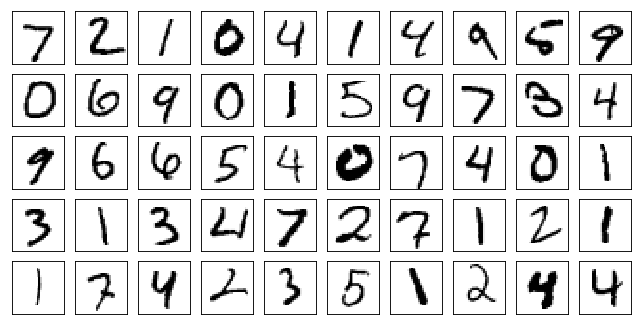

Выход декодера


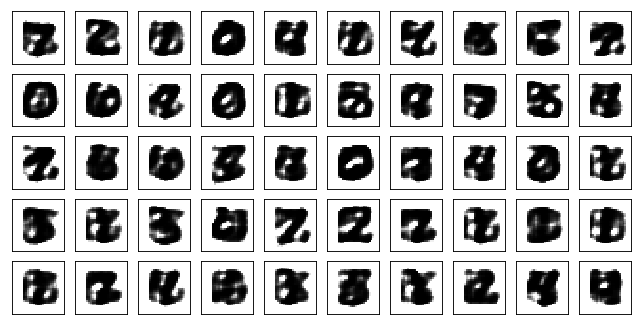

Выход декодера с отсечкой на латентном слое


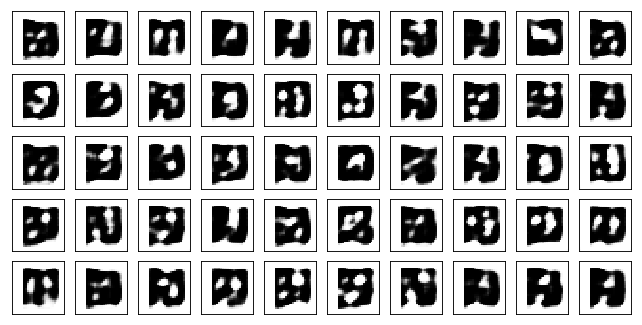

Выход декодера с единичной матрицы


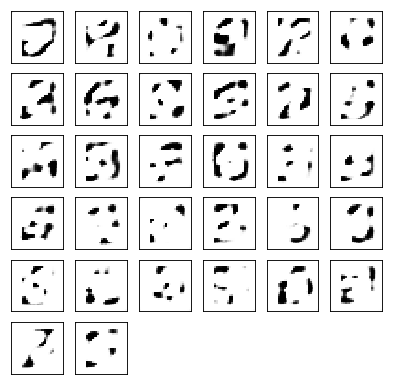

In [20]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

In [21]:
model = torch.load('./adam_l1_2')

In [16]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((np.abs(encoded) > 0.05).sum(1))
    encoded[np.abs(encoded) < 0.05] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 14,  19,   6,   7,  14,   2,  16,  21,  18,  12,  10,  18,
          5,  10,   5,  17,   9,  18,  24,   7,   6,   7,  21,  14,
         11,  18,   9,   7,  12,   9,  12,   9,  12,  22,   8,  18,
         16,   4,  14,   5,   5,   9,   9,  20,  11,   9,  12,  17,
          9,  12])


Исходные данные


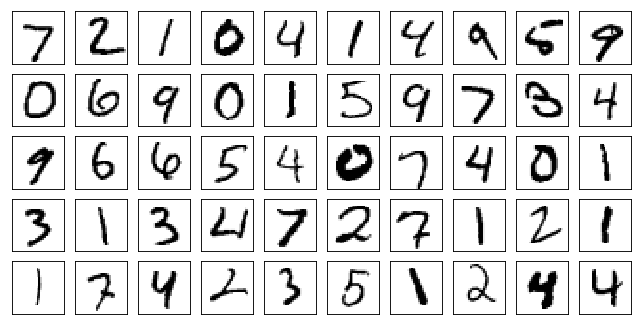

Выход декодера


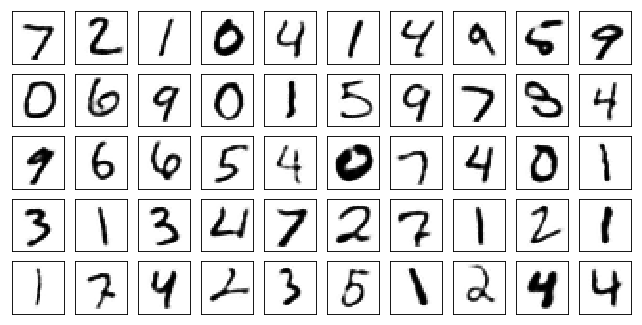

Выход декодера с отсечкой на латентном слое


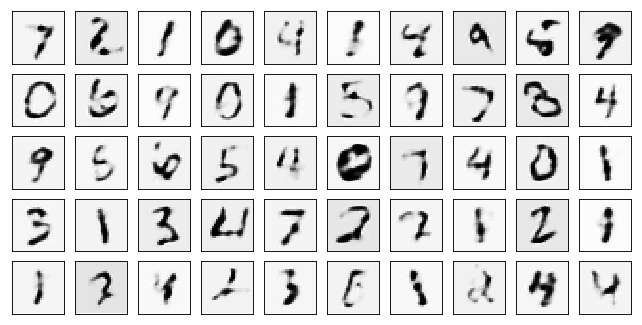

Выход декодера с единичной матрицы


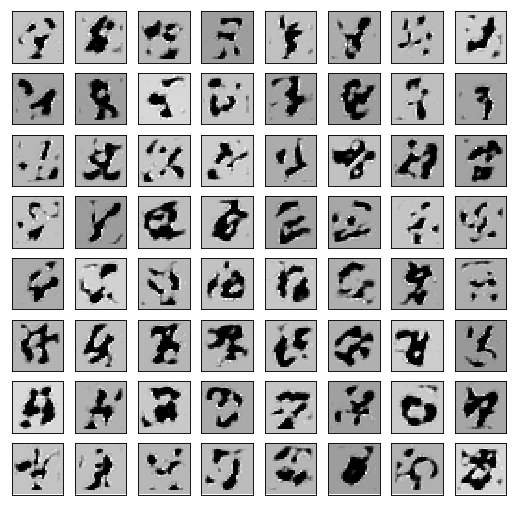

In [17]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (8, 8))

### Оптимизация изображений на входе автокодировщика

In [16]:
model = torch.load('./adam_bn_dp_l1_2')

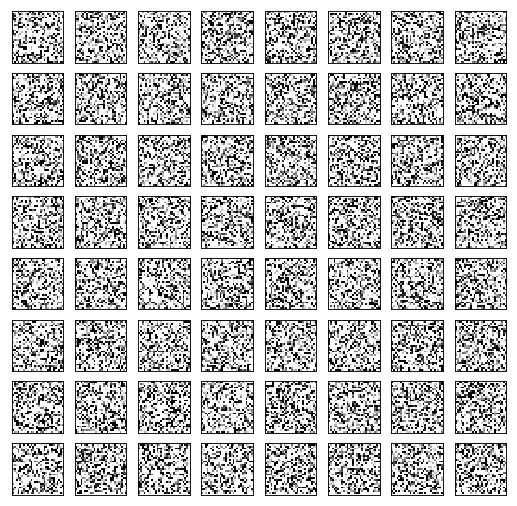

In [17]:
img = torch.randn((64, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [20]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-3
    
    
    for i in range(1, 200001):  
                
        target = model.encode(F.sigmoid(gen_img_par))
                
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
        
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

Iteration 5000: loss=0.019139619544148445
Iteration 10000: loss=0.01700066775083542
Iteration 15000: loss=0.016285696998238564
Iteration 20000: loss=0.015939736738801003
Iteration 25000: loss=0.015738192945718765
Iteration 30000: loss=0.015606974251568317
Iteration 35000: loss=0.015515225939452648
Iteration 40000: loss=0.015447680838406086
Iteration 45000: loss=0.015395917929708958
Iteration 50000: loss=0.015355132520198822


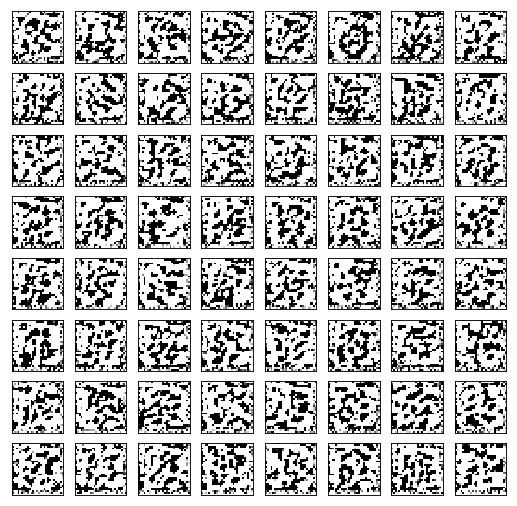

Iteration 55000: loss=0.015322172082960606
Iteration 60000: loss=0.015295018441975117
Iteration 65000: loss=0.015272148884832859
Iteration 70000: loss=0.015252714045345783
Iteration 75000: loss=0.015236030332744122
Iteration 80000: loss=0.015221664682030678
Iteration 85000: loss=0.015209116041660309
Iteration 90000: loss=0.01519802212715149
Iteration 95000: loss=0.015188201330602169
Iteration 100000: loss=0.015179382637143135


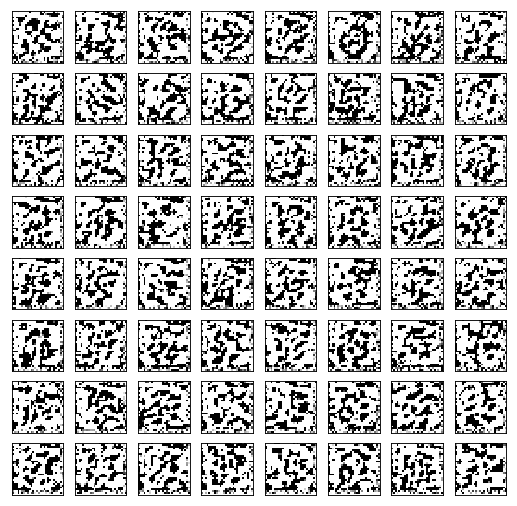

Iteration 105000: loss=0.015171472914516926
Iteration 110000: loss=0.015164347365498543
Iteration 115000: loss=0.015157870016992092
Iteration 120000: loss=0.0151519188657403
Iteration 125000: loss=0.015146390534937382
Iteration 130000: loss=0.015141382813453674
Iteration 135000: loss=0.015136759728193283
Iteration 140000: loss=0.01513249147683382
Iteration 145000: loss=0.015128483064472675
Iteration 150000: loss=0.015124817378818989


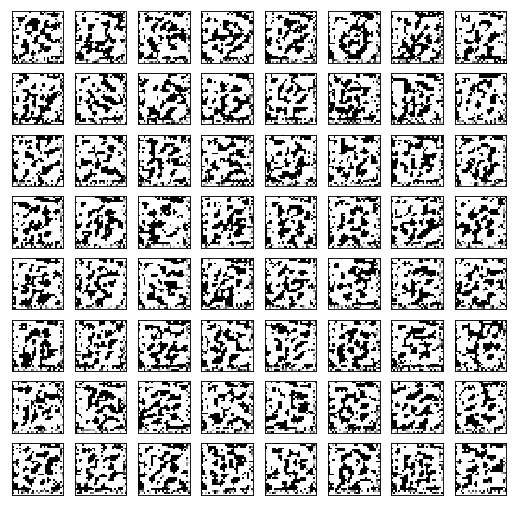

Iteration 155000: loss=0.015121383592486382
Iteration 160000: loss=0.01511816494166851
Iteration 165000: loss=0.015115133486688137
Iteration 170000: loss=0.015112305991351604
Iteration 175000: loss=0.015109660103917122
Iteration 180000: loss=0.015107162296772003
Iteration 185000: loss=0.015104766003787518
Iteration 190000: loss=0.015102536417543888
Iteration 195000: loss=0.015100446529686451
Iteration 200000: loss=0.015098457224667072


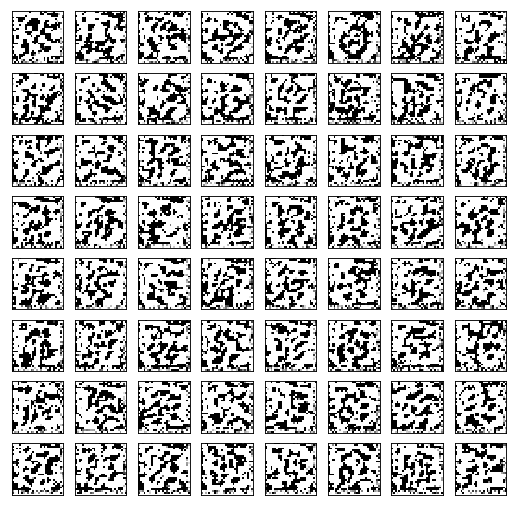

In [21]:
new_image_randn = generate_image(img)

### Оптимизация изображений - фильтры энкодера

In [22]:
def generate_filter_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(16)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 200001):  
                
        target = model._conv1(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target.view(16, 16), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (4, 4))
                        
    return gen_img_par    

In [23]:
img = torch.randn((16, 16)).view(16, 1, 4, 4)

Iteration 5000: loss=0.28584450483322144
Iteration 10000: loss=0.23741278052330017
Iteration 15000: loss=0.2003130167722702
Iteration 20000: loss=0.17346270382404327
Iteration 25000: loss=0.15485630929470062
Iteration 30000: loss=0.14231765270233154
Iteration 35000: loss=0.13409459590911865
Iteration 40000: loss=0.12882813811302185
Iteration 45000: loss=0.125519797205925
Iteration 50000: loss=0.1234680786728859


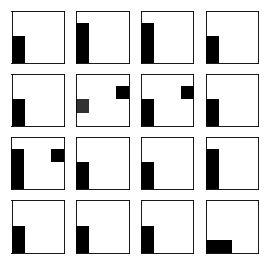

Iteration 55000: loss=0.12220563739538193
Iteration 60000: loss=0.12143252789974213
Iteration 65000: loss=0.12095995247364044
Iteration 70000: loss=0.12067127972841263
Iteration 75000: loss=0.12049435824155807
Iteration 80000: loss=0.12038508802652359
Iteration 85000: loss=0.1203170120716095
Iteration 90000: loss=0.12027385830879211
Iteration 95000: loss=0.1202460527420044
Iteration 100000: loss=0.12022759765386581


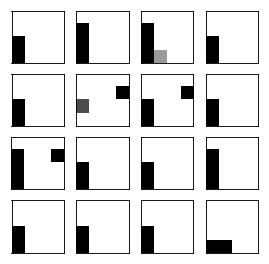

Iteration 105000: loss=0.12021510303020477
Iteration 110000: loss=0.12020626664161682
Iteration 115000: loss=0.12019994109869003
Iteration 120000: loss=0.12019515037536621
Iteration 125000: loss=0.12019149214029312
Iteration 130000: loss=0.12018868327140808
Iteration 135000: loss=0.12018632143735886
Iteration 140000: loss=0.12018449604511261
Iteration 145000: loss=0.12018289417028427
Iteration 150000: loss=0.12018153816461563


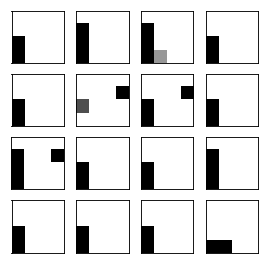

Iteration 155000: loss=0.12018042802810669
Iteration 160000: loss=0.1201794296503067
Iteration 165000: loss=0.12017862498760223
Iteration 170000: loss=0.12017787992954254
Iteration 175000: loss=0.12017720192670822
Iteration 180000: loss=0.12017662078142166
Iteration 185000: loss=0.12017609924077988
Iteration 190000: loss=0.12017563730478287
Iteration 195000: loss=0.12017519026994705
Iteration 200000: loss=0.12017480283975601


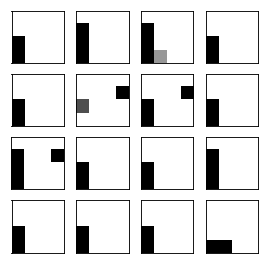

In [24]:
filter_img = generate_filter_image(img)